In [49]:
!pip install pennylane
!pip install matplotlib
!pip install tensorflow
!pip install seaborn


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [51]:
n_epochs = 30   
n_layers = 1    
n_train = 50    
n_test = 30     

SAVE_PATH = "./_static/demonstration_assets/quanvolution/"  
PREPROCESS = True           
np.random.seed(0)           
tf.random.set_seed(0)       

We import the MNIST dataset from Keras. To speed up the evaluation of this demo, we’re only using a small subset of the training and test images. Naturally, using the full dataset would yield better results.

In [52]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

We follow the approach outlined in the introduction and depicted in the figure at the top of this demo.

We begin by initializing a PennyLane default.qubit device, simulating a system of 4 qubits.

In [53]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    RandomLayers(rand_params, wires=list(range(4)))

    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

The next function outlines the convolution scheme:

1. The image is divided into 2×2 pixel squares.
2. Each square is processed by the quantum circuit.
3. The 4 expectation values are mapped into 4 different channels of a single output pixel.

In [54]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

Since we’re not training the quantum convolution layer, it’s more efficient to use it as a “pre-processing” layer for all the images in our dataset. After pre-processing, a purely classical model will be trained and tested on the processed dataset, avoiding unnecessary repetitions of quantum computations.

The pre-processed images will be saved in the folder specified by SAVE_PATH. Once saved, they can be loaded directly by setting PREPROCESS = False. If PREPROCESS is set to True, the quantum convolution will be evaluated each time the code is run.

In [55]:
if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


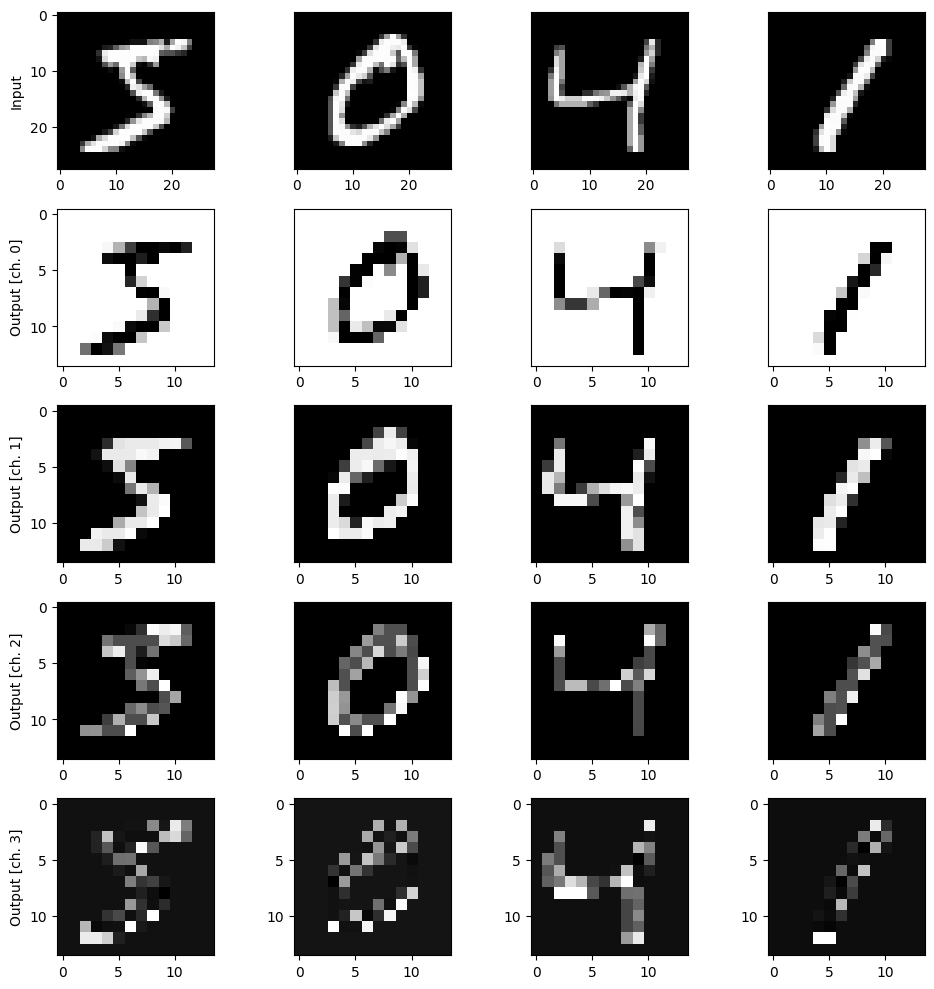

In [56]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Below each input image, you can see the 4 output channels produced by the quantum convolution, displayed in grayscale.

You’ll notice a downsampling of the resolution and some local distortion introduced by the quantum kernel. However, the overall shape of the image is preserved, as you would expect from a convolution layer.

After applying the quantum convolution layer, we pass the resulting features into a classical neural network, which will be trained to classify the 10 different digits in the MNIST dataset.

We use a straightforward model: a fully connected layer with 10 output nodes and a final softmax activation function.

The model is compiled with a stochastic gradient descent optimizer and a cross-entropy loss function.

In [57]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training

We first initialize an instance of the model, then we train and validate it with the dataset that has been already pre-processed by a quantum convolution.



In [58]:
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 0s - 34ms/step - accuracy: 0.1000 - loss: 2.8213 - val_accuracy: 0.2667 - val_loss: 2.3054
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3400 - loss: 1.9595 - val_accuracy: 0.2667 - val_loss: 2.0439
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.5200 - loss: 1.6905 - val_accuracy: 0.3667 - val_loss: 1.9435
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.6400 - loss: 1.3569 - val_accuracy: 0.4333 - val_loss: 1.7833
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8400 - loss: 1.1199 - val_accuracy: 0.4000 - val_loss: 1.6627
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.9000 - loss: 0.9377 - val_accuracy: 0.4333 - val_loss: 1.5809
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.7842 - val_accuracy: 0.4667 - val_loss: 1.5099
Epoch 8/30
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.6638 - val_accuracy: 0.5333 - val_loss: 1.4468
Epoch 9/30
13/13 - 0s - 4ms/step - accuracy: 0.9800 - loss: 0.5674 - val_accuracy: 0.5333 - val_loss: 1.3948
Epoch 10/30
13/13 

To compare the results with and without the quantum convolution layer, we also initialize a "classical" version of the model. This version will be trained and validated directly with the raw MNIST images, without any quantum pre-processing.

In [59]:
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 47ms/step - accuracy: 0.1600 - loss: 2.3216 - val_accuracy: 0.3667 - val_loss: 2.0281
Epoch 2/30
13/13 - 0s - 4ms/step - accuracy: 0.4600 - loss: 1.9104 - val_accuracy: 0.3667 - val_loss: 1.9121
Epoch 3/30
13/13 - 0s - 4ms/step - accuracy: 0.6800 - loss: 1.6254 - val_accuracy: 0.5000 - val_loss: 1.8010
Epoch 4/30
13/13 - 0s - 4ms/step - accuracy: 0.8200 - loss: 1.3941 - val_accuracy: 0.6333 - val_loss: 1.6921
Epoch 5/30
13/13 - 0s - 4ms/step - accuracy: 0.8600 - loss: 1.2016 - val_accuracy: 0.6333 - val_loss: 1.5924
Epoch 6/30
13/13 - 0s - 4ms/step - accuracy: 0.9200 - loss: 1.0411 - val_accuracy: 0.7333 - val_loss: 1.5066
Epoch 7/30
13/13 - 0s - 4ms/step - accuracy: 0.9400 - loss: 0.9073 - val_accuracy: 0.7333 - val_loss: 1.4346
Epoch 8/30
13/13 - 0s - 6ms/step - accuracy: 0.9800 - loss: 0.7955 - val_accuracy: 0.7333 - val_loss: 1.3743
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9800 - loss: 0.7015 - val_accuracy: 0.7667 - val_loss: 1.3235
Epoch 10/30
13/13 

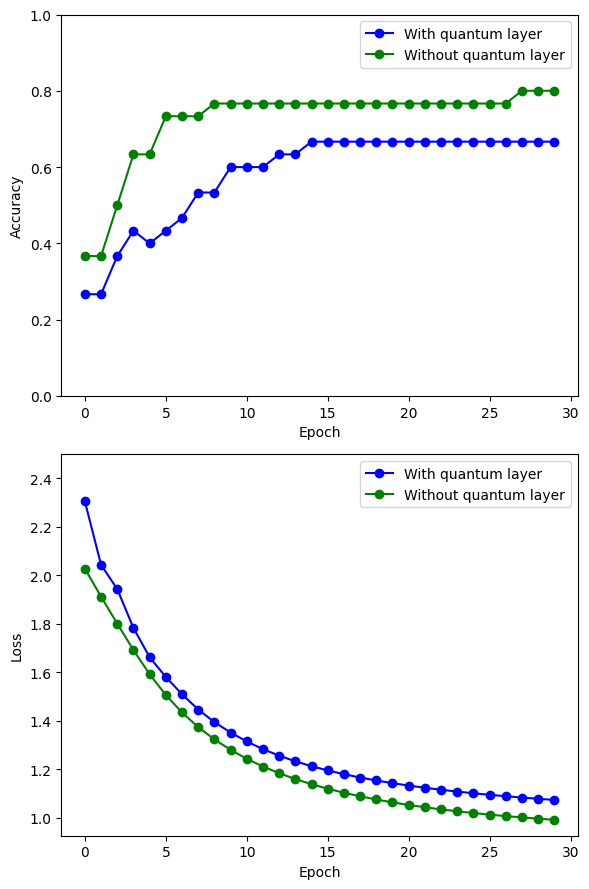

In [60]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()